In [2]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import random

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Gather the data.

- **Twitter archive enhanced.**

In [3]:
# load the twitter archive enhanced CSV file 
df_tw_arc = pd.read_csv('twitter-archive-enhanced.csv')
df_tw_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
df_tw_arc.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Sample of tweet data**

In [5]:
#Uses sample() to randomly select obeservations.
sample_tw = df_tw_arc.sample(3)
sample_tw

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1561,688385280030670848,NaN,NaN,2016-01-16 15:40:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Louis. He's takes top-notch selfies. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688385280...,12,10,Louis,None,None,None,None
1834,676121918416756736,NaN,NaN,2015-12-13 19:30:01 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a very excited dog. Cle...,NaN,NaN,NaN,https://vine.co/v/iZXg7VpeDAv,8,10,None,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None


In [6]:
#Display text column data of the chosen observations.
sample_tw.text

1561    This is Louis. He's takes top-notch selfies. 1...
1834    Here we are witnessing a very excited dog. Cle...
24      You may not have known you needed to see this ...
Name: text, dtype: object

In [7]:
#Display expanded_urls column data of the chosen observations.
sample_tw.expanded_urls

1561    https://twitter.com/dog_rates/status/688385280...
1834                        https://vine.co/v/iZXg7VpeDAv
24      https://twitter.com/dog_rates/status/887343217...
Name: expanded_urls, dtype: object

- **Image prediction.**

In [8]:
#Download the image predictions TSV file.
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [9]:
file_images = url.split('/')[-1]

with open(os.path.join('./', file_images), mode = 'wb') as file:
    file.write(response.content)

In [10]:
#Load image predictions file.
df_predict = pd.read_csv(file_images, sep = '\\t', engine = 'python')
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
df_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
#Display three random observations.
df_predict.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
941,704054845121142784,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True
1485,781661882474196992,https://pbs.twimg.com/media/CtkFS72WcAAiUrs.jpg,1,Pembroke,0.438087,True,golden_retriever,0.226954,True,collie,0.070652,True
1815,833826103416520705,https://pbs.twimg.com/media/C5JYaYoVYAAcEQw.jpg,1,Chihuahua,0.438054,True,kelpie,0.149706,True,Pembroke,0.096480,True


- **JSON Data.**                                                                                                        

In [12]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_tw_arc is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_tw_arc.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

**Load JSON data file into dataframe**

In [13]:
# Create tw_json list.
tw_json = []

with open('tweet_json.txt') as file:
    for line in file:
        tw_json.append(json.loads(line))

In [14]:
print(tw_json[3])

{'created_at': 'Sun Jul 30 15:58:51 +0000 2017', 'id': 891689557279858688, 'id_str': '891689557279858688', 'full_text': 'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ', 'truncated': False, 'display_text_range': [0, 79], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg', 'url': 'https://t.co/tD36da7qLQ', 'display_url': 'pic.twitter.com/tD36da7qLQ', 'expanded_url': 'https://twitter.com/dog_rates/status/891689557279858688/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 901, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1201, 'h': 1600, 'resize': 'fit'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}}}]}, 'extended_entities': {'media': 

In [15]:
#Creating Dataframe from tw_json list
df_json = pd.DataFrame(tw_json, columns = ['id',
                                         'retweet_count',
                                         'favorite_count'])

In [16]:
#Use rename() to rename id column to tweet_id.
df_json = df_json.rename(columns = {'id':'tweet_id',
                                    'retweet_count':'retweet',
                                   'favorite_count':'favorites'})
df_json

,tweet_id,retweet,favorites
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [17]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2354 non-null   int64
 1   retweet    2354 non-null   int64
 2   favorites  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


## 2. Assess the data.

- **Visual Assessment.**

In [18]:
df_tw_arc

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [19]:
df_tw_arc.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1032,745314880350101504,NaN,NaN,2016-06-21 17:58:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sugar. She excels underwater. 12/10 ph...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745314880...,12,10,Sugar,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1864,675362609739206656,NaN,NaN,2015-12-11 17:12:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Daisy. She loves that shoe. Still no s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675362609...,12,10,Daisy,None,None,None,None
752,778990705243029504,NaN,NaN,2016-09-22 16:13:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jay. He's really h*ckin happy about th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778990705...,11,10,Jay,None,None,None,None
1622,684914660081053696,NaN,NaN,2016-01-07 01:49:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Hello yes I'll just get one of each color tha...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684914660...,12,10,None,None,None,None,None
1378,701570477911896070,NaN,NaN,2016-02-22 00:53:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Yoda. He's a Zimbabwean Rutabaga. Frea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701570477...,9,10,Yoda,None,None,None,None
1322,706291001778950144,NaN,NaN,2016-03-06 01:31:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're just relaxin and having a swell ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706291001...,11,10,None,None,None,None,None
2093,670780561024270336,NaN,NaN,2015-11-29 01:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Traviss. He has no ears. Two rare dogs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670780561...,7,10,Traviss,None,None,None,None
491,813800681631023104,NaN,NaN,2016-12-27 17:36:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sky. She's learning how to roll her R'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813800681...,12,10,Sky,None,None,None,None
831,768609597686943744,NaN,NaN,2016-08-25 00:43:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. His sweater is too small and he a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768609597...,10,10,Lou,None,None,None,None


In [20]:
df_predict

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [21]:
df_json

,tweet_id,retweet,favorites
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


- **Programmatic Assessment.**

In [22]:
df_tw_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [23]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2354 non-null   int64
 1   retweet    2354 non-null   int64
 2   favorites  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [25]:
#Display the values in the name column.
df_tw_arc.name.value_counts().head(20)

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
Cooper      11
Lola        10
Penny       10
Tucker      10
Bo           9
Winston      9
Sadie        8
the          8
Buddy        7
Bailey       7
Toby         7
an           7
Daisy        7
Dave         6
Milo         6
Name: name, dtype: int64

In [26]:
#Names with lowercase
lowercase_word = df_tw_arc.name.str.contains('^[a-z]', regex = True)
df_tw_arc[lowercase_word].name.value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
not              2
getting          2
actually         2
mad              2
incredibly       1
his              1
this             1
life             1
space            1
unacceptable     1
infuriating      1
my               1
old              1
all              1
officially       1
light            1
by               1
such             1
Name: name, dtype: int64

In [27]:
#The number of missing urls associated with tweets.
sum(df_tw_arc.expanded_urls.isna())

59

In [28]:
#Types of source, the source type is the text between rel="nofollow"> and </a>.
df_tw_arc.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [29]:
#Display rating_numerator values.
df_tw_arc.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [30]:
#Display rating_denominator values.
df_tw_arc.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

**The quality/tidness issues**:

1- The dtype of **retweeted_status_id & retweeted_status_user_id** columns is float, should be str(object).(Quality issue)                                                                           

2- The dtype of **timestamp** is str(object), should be datetime.(Quality issue)                                                 
3- The dtype of **in_reply_to_user_id & in_reply_to_status_id** columns is float, should be str(object).(Quality issue)                           

4- The **retweeted_status_id, retweeted_status_user_id & retweeted_status_timestamp** have 181 records of retweets, while **in_reply_to_user_id & in_reply_to_status_id** have 78 records of replies, and We need the original tweets only.(Tidness issue)

5- There're 2297 records in the **expanded_urls** column, 59 tweets with missing data.(Quality issue)                                                       
6- There're 4 columns for dog stage **(doggo, floofer, pupper, puppo)**, should be in one column.(Tidness issue)                 
7- Invalid data in the **name** column like: a, an & None, also the lowercase words.(Quality issue)                                                                         
8- There're only **four types of sources**, and we can simplified by extract source name.(Quality issue) 

9- Fix the **numerator and denominator** columns incorrect values.(Quality issue)

10- **'NaN'** invalid values in different columns.(Quality issue)                                                                                                                

## 3. Clean the data.

In [31]:
#Create copies of each Dataframe
tw_arc_clean = df_tw_arc.copy()
predict_clean = df_predict.copy()
json_clean = df_json.copy()

- **Merge the copies of the DataFrames into one dataframe.**

**Code**

In [32]:
#Merge the copies of the DataFrames.
dfs = pd.merge(left= tw_arc_clean,
                                 right= json_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [33]:
dfs = dfs.merge(predict_clean, on='tweet_id', how='inner')

**Test**

In [34]:
#Check
dfs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweet', 'favorites', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

- **We only need the original tweets.**

**Code**

In [35]:
#We're not intersted in retweets and replies.
print("There\'re {} Retweets".format(sum(dfs.retweeted_status_id.notnull())))
print("There\'re {} Replies".format(sum(dfs.in_reply_to_status_id.notnull())))
print("There\'re {} Tweets".format(sum(dfs.retweeted_status_id.isna())))

There're 79 Retweets
There're 23 Replies
There're 1994 Tweets


In [36]:
#Remove retweets
dfs = dfs[dfs.retweeted_status_id.isnull()]
dfs = dfs[dfs.retweeted_status_user_id.isnull()]
dfs = dfs[dfs.retweeted_status_timestamp.isnull()]

In [37]:
#No need to change the dtype of these cloumns Since we're intersted only in tweets, we will just drop all them.
dfs = dfs.drop(['retweeted_status_id',
                                'retweeted_status_user_id',
                                    'retweeted_status_timestamp',
                                        'in_reply_to_status_id',
                                             'in_reply_to_user_id'], axis = 1)

**Test**

In [38]:
#Check
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp           1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1994 non-null   object 
 8   doggo               1994 non-null   object 
 9   floofer             1994 non-null   object 
 10  pupper              1994 non-null   object 
 11  puppo               1994 non-null   object 
 12  retweet             1994 non-null   int64  
 13  favorites           1994 non-null   int64  
 14  jpg_url             1994 non-null   object 
 15  img_num             1994 non-null   int64  
 16  p1    

- **The dtype of timestamp is string(object), should be datetime.** 

**Code**

In [39]:
#We will keep this column but we need to change its dtype to a datetime.
dfs['timestamp'] = pd.to_datetime(dfs.timestamp)

**Test**

In [40]:
#Confirm changes.
dfs.dtypes

tweet_id                            int64
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
retweet                             int64
favorites                           int64
jpg_url                            object
img_num                             int64
p1                                 object
p1_conf                           float64
p1_dog                               bool
p2                                 object
p2_conf                           float64
p2_dog                               bool
p3                                 object
p3_conf                           

- **Drop all tweets with missing urls.**

**Code**

In [41]:
#Remove tweets with missing urls.
dfs = dfs[tw_arc_clean.expanded_urls.notnull()]

<ipython-input-41-dd0410beaf1b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfs = dfs[tw_arc_clean.expanded_urls.notnull()]


**Test**

In [42]:
#Check
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1940 entries, 0 to 2072
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1940 non-null   int64              
 1   timestamp           1940 non-null   datetime64[ns, UTC]
 2   source              1940 non-null   object             
 3   text                1940 non-null   object             
 4   expanded_urls       1940 non-null   object             
 5   rating_numerator    1940 non-null   int64              
 6   rating_denominator  1940 non-null   int64              
 7   name                1940 non-null   object             
 8   doggo               1940 non-null   object             
 9   floofer             1940 non-null   object             
 10  pupper              1940 non-null   object             
 11  puppo               1940 non-null   object             
 12  retweet             1940 non-null 

- **Fix the numerator and denominator columns incorrect values.**

**Code - 1**

In [43]:
#We want only keep the tweets with rating_denominator that are equal to 10.
dfs = dfs[dfs.rating_denominator == 10]

**Test - 1**

In [44]:
#Check
dfs.rating_denominator.value_counts()

10    1923
Name: rating_denominator, dtype: int64

**Code - 2**

In [45]:
#We want only keep the tweets with rating_numerator that are less than 15.
dfs = dfs[dfs.rating_numerator < 15]

**Test - 2**

In [46]:
#Check
dfs.rating_numerator.value_counts().sort_index(ascending = False)

14     35
13    249
12    438
11    387
10    407
9     147
8      93
7      51
6      31
5      33
4      13
3      19
2       9
1       4
0       2
Name: rating_numerator, dtype: int64

- **There're 4 columns for dog stage (doggo, floofer, pupper, puppo).**

**Code**

In [47]:
#Create dog stage column.
dfs.loc[dfs.doggo == 'None', 'doggo'] = ''
dfs.loc[dfs.floofer == 'None', 'floofer'] = ''
dfs.loc[dfs.pupper == 'None', 'pupper'] = ''
dfs.loc[dfs.puppo == 'None', 'puppo'] = ''

dfs.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1618
1,,,,puppo,22
2,,,pupper,,199
3,,floofer,,,7
4,doggo,,,,61
5,doggo,,,puppo,1
6,doggo,,pupper,,9
7,doggo,floofer,,,1


In [48]:
dfs['dog_stage'] = dfs.doggo + dfs.floofer + dfs.pupper + dfs.puppo
dfs.loc[dfs.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
dfs.loc[dfs.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
dfs.loc[dfs.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

dfs.loc[dfs.dog_stage == '', 'dog_stage'] = 'None'

In [49]:
#Remove duplicate dog_stage.
dfs = dfs.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

In [50]:
#Remove unnecessary columns.
dfs = dfs.drop(['doggo', 'floofer', 
                            'pupper', 'puppo'], 1)

**Test**

In [51]:
#Check
dfs.dog_stage.value_counts()

None             1618
pupper            199
doggo              61
puppo              22
doggo,pupper        9
floofer             7
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

- **Invalid data in the name column like: a, an & None, also the lowercase words.** 

**Code**

In [52]:
#Use replace() function to change the lowercase names to 'None'.
dfs.name = dfs.name.str.replace('^[a-z]+', 'None')

<ipython-input-52-df756feec526>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dfs.name = dfs.name.str.replace('^[a-z]+', 'None')


**Test**

In [53]:
#Check
dfs.name.value_counts()

None       616
Charlie     11
Oliver      10
Lucy        10
Cooper      10
          ... 
Sully        1
Carter       1
Chesney      1
Millie       1
Blipson      1
Name: name, Length: 893, dtype: int64

- **There're only 4 types of sources, and we can simplified by extract() source name.**

**Code**

In [54]:
#Uses extract() function to only the source text.
dfs['source'] = dfs['source'].str.extract('^<a.+>(.+)</a>$')

**Test**

In [55]:
#Check.
dfs.source.value_counts()

Twitter for iPhone    1882
Twitter Web Client      26
TweetDeck               10
Name: source, dtype: int64

- **Create dog_breed & confidence columns using image predictions data.**  

**Code**

In [56]:
#Uses append() to predict dog breed.
dog_breed = []
confidence = []

def dog_breed_fun(dataframe):
    if dataframe['p1_dog'] == True:
        dog_breed.append(dataframe['p1'])
        confidence.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        dog_breed.append(dataframe['p2'])
        confidence.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        dog_breed.append(dataframe['p3'])
        confidence.append(dataframe['p3_conf'])
    else:
        dog_breed.append('NaN')
        confidence.append(0)

dfs.apply(dog_breed_fun, axis=1)
dfs['dog_breed'] = dog_breed
dfs['confidence'] = confidence



# Remove unnecessary columns
dfs = dfs.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                    'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

In [57]:
#Change 'Nan' values to None.
dfs.loc[dfs['dog_breed'] == 'NaN', 'dog_breed'] = None
dfs.loc[dfs['rating_numerator'] == 'NaN', 'rating_numerator'] = 0

**Test**

In [58]:
#Check
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1918 entries, 0 to 518
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1918 non-null   int64              
 1   timestamp           1918 non-null   datetime64[ns, UTC]
 2   source              1918 non-null   object             
 3   text                1918 non-null   object             
 4   expanded_urls       1918 non-null   object             
 5   rating_numerator    1918 non-null   int64              
 6   rating_denominator  1918 non-null   int64              
 7   name                1918 non-null   object             
 8   retweet             1918 non-null   int64              
 9   favorites           1918 non-null   int64              
 10  jpg_url             1918 non-null   object             
 11  dog_stage           1918 non-null   object             
 12  dog_breed           1621 non-null  

In [59]:
#Check once again.
dfs.iloc[7]

tweet_id                                             684200372118904832
timestamp                                     2016-01-05 02:30:55+00:00
source                                               Twitter for iPhone
text                  Gang of fearless hoofed puppers here. Straight...
expanded_urls         https://twitter.com/dog_rates/status/684200372...
rating_numerator                                                      6
rating_denominator                                                   10
name                                                               None
retweet                                                            1177
favorites                                                          2394
jpg_url                 https://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg
dog_stage                                                          None
dog_breed                                                          None
confidence                                                      

## 4. **Store the data**

**Now we need to store the cleaned dataset into twitter_archive_master.csv before we analyze it.**

In [60]:
dfs.drop(dfs.columns[dfs.columns.str.contains('Unnamed',case = False)],axis = 1)
dfs.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

dfs = pd.read_csv('twitter_archive_master.csv')
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1918 non-null   int64  
 1   timestamp           1918 non-null   object 
 2   source              1918 non-null   object 
 3   text                1918 non-null   object 
 4   expanded_urls       1918 non-null   object 
 5   rating_numerator    1918 non-null   int64  
 6   rating_denominator  1918 non-null   int64  
 7   name                1918 non-null   object 
 8   retweet             1918 non-null   int64  
 9   favorites           1918 non-null   int64  
 10  jpg_url             1918 non-null   object 
 11  dog_stage           1918 non-null   object 
 12  dog_breed           1621 non-null   object 
 13  confidence          1918 non-null   float64
dtypes: float64(1), int64(5), object(8)
memory usage: 209.9+ KB


## 5.  Analyze & visualize the data.

In [61]:
#Read twitter_archive_master csv file
df = pd.read_csv('twitter_archive_master.csv')

In [62]:
df.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet,favorites,jpg_url,dog_stage,dog_breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,None,NaN,0.000000
1,683857920510050305,2016-01-04 03:50:08+00:00,Twitter for iPhone,Meet Sadie. She fell asleep on the beach and h...,https://twitter.com/dog_rates/status/683857920...,10,10,Sadie,1262,4163,https://pbs.twimg.com/media/CX2NJmRWYAAxz_5.jpg,None,bluetick,0.174738
2,684097758874210310,2016-01-04 19:43:10+00:00,Twitter for iPhone,Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10,10,Lupe,1621,4515,https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,None,Labrador_retriever,0.627856
3,684122891630342144,2016-01-04 21:23:02+00:00,Twitter for iPhone,Heartwarming scene of two pups that want nothi...,https://twitter.com/dog_rates/status/684122891...,11,10,None,539,2176,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,None,NaN,0.000000
4,684177701129875456,2016-01-05 01:00:50+00:00,Twitter for iPhone,This is Kulet. She's very proud of the flower ...,https://twitter.com/dog_rates/status/684177701...,10,10,Kulet,764,2215,https://pbs.twimg.com/media/CX6v_JOWsAE0beZ.jpg,None,chow,0.334783
5,684188786104872960,2016-01-05 01:44:52+00:00,Twitter for iPhone,"""Yo Boomer I'm taking a selfie, grab your stic...",https://twitter.com/dog_rates/status/684188786...,10,10,None,1343,3831,https://pbs.twimg.com/media/CX66EiJWkAAVjA-.jpg,None,kelpie,0.537782
6,684195085588783105,2016-01-05 02:09:54+00:00,Twitter for iPhone,This is Tino. He really likes corndogs. 9/10 h...,https://twitter.com/dog_rates/status/684195085...,9,10,Tino,595,2108,https://pbs.twimg.com/media/CX6_y6OU0AAl3v2.jpg,None,Chihuahua,0.379365
7,684200372118904832,2016-01-05 02:30:55+00:00,Twitter for iPhone,Gang of fearless hoofed puppers here. Straight...,https://twitter.com/dog_rates/status/684200372...,6,10,None,1177,2394,https://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg,None,NaN,0.000000
8,684241637099323392,2016-01-05 05:14:53+00:00,Twitter for iPhone,This is Obi. He got camera shy. 12/10 https://...,https://twitter.com/dog_rates/status/684241637...,12,10,Obi,3727,8999,https://pbs.twimg.com/media/CX7qIcdWcAELJ7N.jpg,None,Pembroke,0.508498
9,684460069371654144,2016-01-05 19:42:51+00:00,Twitter for iPhone,This is Jeph. He's a Western Sagittarius Dookm...,https://twitter.com/dog_rates/status/684460069...,10,10,Jeph,628,2169,https://pbs.twimg.com/media/CX-wzZEUwAA4ISM.jpg,None,Labrador_retriever,0.673691


**Favorites Vs. Retweets**

In [63]:
#The number of tweets that have more than 10,000 count.
print("Tweets with more than 10,000 fav is: {} ".format(sum(df.favorites > 10000)))
print("Tweets with more than 10,000 retweets is: {} ".format(sum(df.retweet > 10000)))

Tweets with more than 10,000 fav is: 534 
Tweets with more than 10,000 retweets is: 83 


In [64]:
#The top favorited tweet.
df.sort_values(by = 'favorites', ascending = False).head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet,favorites,jpg_url,dog_stage,dog_breed,confidence
1916,822872901745569793,2017-01-21 18:26:02+00:00,Twitter for iPhone,Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,48265,132810,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,puppo,Lakeland_terrier,0.196015


In [65]:
df.iloc[1916]

tweet_id                                             822872901745569793
timestamp                                     2017-01-21 18:26:02+00:00
source                                               Twitter for iPhone
text                  Here's a super supportive puppo participating ...
expanded_urls         https://twitter.com/dog_rates/status/822872901...
rating_numerator                                                     13
rating_denominator                                                   10
name                                                               None
retweet                                                           48265
favorites                                                        132810
jpg_url                 https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
dog_stage                                                         puppo
dog_breed                                              Lakeland_terrier
confidence                                                     0

In [66]:
#The most retweeted.
df.sort_values(by = 'retweet', ascending = False).head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet,favorites,jpg_url,dog_stage,dog_breed,confidence
1674,744234799360020481,2016-06-18 18:26:18+00:00,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,79515,131075,https://pbs.twimg.com/ext_tw_video_thumb/74423...,doggo,Labrador_retriever,0.825333


In [67]:
df.iloc[1674]

tweet_id                                             744234799360020481
timestamp                                     2016-06-18 18:26:18+00:00
source                                               Twitter for iPhone
text                  Here's a doggo realizing you can stand in a po...
expanded_urls         https://twitter.com/dog_rates/status/744234799...
rating_numerator                                                     13
rating_denominator                                                   10
name                                                               None
retweet                                                           79515
favorites                                                        131075
jpg_url               https://pbs.twimg.com/ext_tw_video_thumb/74423...
dog_stage                                                         doggo
dog_breed                                            Labrador_retriever
confidence                                                     0

There're **534 tweets with more than 10,000 favorites** in this dataset, and there are **83 tweets with more than 10,000 retweets**. 

In fact, we found that the most favorite tweet has **132,810 favs**, while the most retweeted tweet has **79,515 retweets**.

**Which the most common dog names and which not ?**

In [68]:
#The common and not common dog names.
df.name.value_counts()

None       616
Charlie     11
Oliver      10
Lucy        10
Cooper      10
          ... 
Sully        1
Carter       1
Chesney      1
Millie       1
Blipson      1
Name: name, Length: 893, dtype: int64

**Charlie** is the most common dog name, then **Oliver, Lucy and Cooper**. Whereas, these names: **Blipson, Millie & Carter** are less common.

**Which is the most common dog breed and which's not ?**

In [69]:
#The most common dog breeds.
breeds_count = \
df[df.dog_breed != 'none'].dog_breed.value_counts().head(10)
print(breeds_count)

percentage = round(sum(breeds_count) * 100 / df.shape[0])
print("\n The most commun dog breeds represent {}% of all tweets.".format(percentage))

golden_retriever      151
Labrador_retriever    104
Pembroke               93
Chihuahua              85
pug                    61
toy_poodle             51
chow                   46
Pomeranian             40
Samoyed                38
malamute               31
Name: dog_breed, dtype: int64

 The most commun dog breeds represent 36% of all tweets.


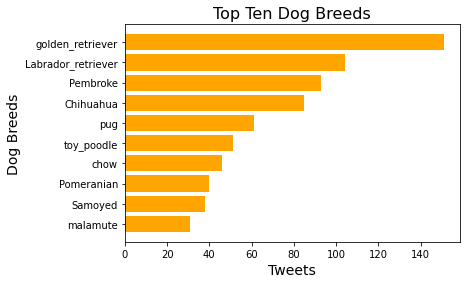

In [70]:
#Visualization of the most common dog breeds.
plt.barh(breeds_count.index, breeds_count, color='orange')
plt.xlabel('Tweets', fontsize = 14)
plt.ylabel('Dog Breeds', fontsize = 14)
plt.title('Top Ten Dog Breeds', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

**The golden retriever** is the most common dog breed in this dataset where there's **151 dogs of this breed**. After it there's **104 Labrador retrievers**, then **93 dogs of Pembroke and 85 dogs of Chihuahua**.

**Which is the most used source?**

In [71]:
df.source.value_counts()

Twitter for iPhone    1882
Twitter Web Client      26
TweetDeck               10
Name: source, dtype: int64

**The Twitter Web Client and TweetDeck** are rarely used sources. While, the most source used to generate the tweets is **Twitter for iPhone**